In [ ]:
import pandas as pd
import librosa as lb
import soundfile as sf
import tensorflow_addons as tfa
import tensorflow_io as tfio
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, Sequential, layers, optimizers, callbacks
from tensorflow.keras.layers import Dense, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Recall
import sklearn
import seaborn as sns
from tensorflow_addons.metrics import F1Score
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
### --- Data --- ###
ROOT_PATH = 'drive/MyDrive/Deep_Breath/'
PROCESSED_DF = ROOT_PATH + 'processed_dataframe/label_data1.csv'
PROCESSED_AUDIO_FOLDER = ROOT_PATH + 'processed_audio_files'

### --- Dataset --- ###
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32

# Part 1 : Split the audio

There are a total of 960 audio files in this dataset with varying length(10s-90s). They all together contain more than 6000 respiratory cycles. 

Objecive: splitting each individual sound file into seprate sound clips containing respiiratory cycle. This allows our model to take a closer look at each respiratory cycle and learn better! 

## 1.1 Load the Data

In [ ]:
audio_df = pd.read_csv('/content/drive/My Drive/Deep_Breath/raw_data/archive/Respiratory_Sound_Database/audio_and_txt_files/combined.txt', sep='\t', 
                          names = ['start', "end", 'crackles','wheezes', 'filename'])


for index, row in audio_df.iterrows():
  temp = row['filename'] .strip('.txt')
  audio_df.loc[index, 'filename'] = temp

In [ ]:
audio_df.head()

,start,end,crackles,wheezes,filename
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron


## 1.2 Understand the length distribution of reaspiratory cycle

In [ ]:
'''Objective : calculate the duraction of each respiratory cycle'''

audio_df['Duration'] =audio_df['end'] - audio_df['start']

In [ ]:
for index, row in audio_df.iterrows():
    temp_list = []
    temp_list.append(row['filename'].split("_"))
    audio_df.loc[index, 'Patient number'] = temp_list[0][0]
    
audio_df['Patient number'] =  audio_df['Patient number'].astype(int)

In [ ]:
audio_df.head()

,start,end,crackles,wheezes,filename,Duration,Patient number
0,0.036,0.579,0,0,101_1b1_Al_sc_Meditron,0.543,101
1,0.579,2.450,0,0,101_1b1_Al_sc_Meditron,1.871,101
2,2.450,3.893,0,0,101_1b1_Al_sc_Meditron,1.443,101
3,3.893,5.793,0,0,101_1b1_Al_sc_Meditron,1.900,101
4,5.793,7.521,0,0,101_1b1_Al_sc_Meditron,1.728,101


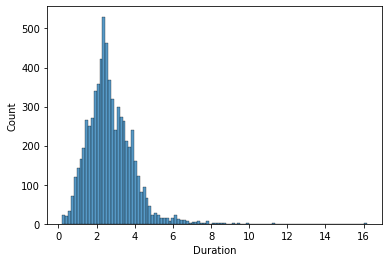

In [ ]:
'''Objective : visualise the length distribution of respiratory cycle'''

sns.histplot(audio_df['Duration']);


Separate sound clips ➡️   1️⃣   respiratory cycle each

6-second long 👍🏻 

97% of respiratory cycles are within 6-second long. It is a suitable length as it won't lose a lot of information while it can save the computational cost and allow our model to learn better.


## 1.3 Split audio and save the processed audio


In [ ]:
def getPureSample(raw_data,start,end,sr=22050):
    '''
    Takes a numpy array and splits its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    
    '''
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

In [ ]:
path = ROOT_PATH +'raw_data/archive/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'

In [ ]:
i,c=0,0
for index,row in audio_df.iterrows():
    maxLen=6
    start=row['start']
    end=row['end']
    filename=row['filename']
    
    #If len > maxLen , change it to maxLen
    if end-start>maxLen:
        end=start+maxLen
    
    audio_file_loc=path + filename + '.wav'
    
    if index > 0:
        #check if more cycles exits for same patient if so then add i to change filename
        if data.iloc[index-1]['filename']==filename:
            i+=1
        else:
            i=0
    filename= filename + '_' + str(i) + '.wav'
    
    save_path=main +'processed_audio_files/' + filename
    c+=1
    try :
      audioArr,sampleRate=lb.load(audio_file_loc)
      pureSample=getPureSample(audioArr,start,end,sampleRate)
      
      #pad audio if pureSample len < max_len
      reqLen=6*sampleRate
      padded_data = lb.util.pad_center(pureSample, reqLen)
      
      sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
    except :
      print('An exception occured on the file :' , audio_file_loc)
print('Total Files Processed: ',c)

## 1.4 Update file name & file path and save the dataframe

In [ ]:
i=0
for index,row in audio_df.iterrows():
    filename=row['filename']
    if audio_df.iloc[index-1]['filename']==filename:
      i+=1
    else:
      i=0

    audio_df.loc[index, 'new_filename'] = filename + '_' + str(i) + '.wav'

In [ ]:
def add_path(df):
    for index, row in df.iterrows():
      df.loc[index, 'Path'] = ROOT_PATH + 'processed_audio_files/' + row['filename']
    
add_path(audio_df)

In [ ]:
audio_df = audio_df.drop(columns = ['filename', 'start', 'end', 'Duration']).rename(columns ={'new_filename': 'filename'})

In [ ]:
audio_df.head()

,crackles,wheezes,Patient number,filename,Path
0,0,0,101,101_1b1_Al_sc_Meditron_0.wav,drive/MyDrive/Deep_Breath/processed_audio_file...
1,0,0,101,101_1b1_Al_sc_Meditron_1.wav,drive/MyDrive/Deep_Breath/processed_audio_file...
2,0,0,101,101_1b1_Al_sc_Meditron_2.wav,drive/MyDrive/Deep_Breath/processed_audio_file...
3,0,0,101,101_1b1_Al_sc_Meditron_3.wav,drive/MyDrive/Deep_Breath/processed_audio_file...
4,0,0,101,101_1b1_Al_sc_Meditron_4.wav,drive/MyDrive/Deep_Breath/processed_audio_file...


In [ ]:
'''save the dataframe'''
audio_df.to_csv(ROOT_PATH+'processed_dataframe/label_data1.csv',index=False)

# Part 2: Prepare dataset 

Objective 1: make a more balanced dataset


Objective 2: label our targets


Objective 3: prepare train/test/val dataset

## 2.1 Load the data

In [ ]:
diagnosis_df = pd.read_csv('/content/drive/My Drive/Deep_Breath/raw_data/archive/Respiratory_Sound_Database/patient_diagnosis.csv',  names=['Patient number', "Diagnosis"])
diagnosis_df.head()
data = pd.read_csv(PROCESSED_DF)
data = data.merge(diagnosis_df, on = 'Patient number')
data.head()

,crackles,wheezes,Patient number,filename,Path,Diagnosis
0,0,0,101,101_1b1_Al_sc_Meditron_0.wav,drive/MyDrive/Deep_Breath/processed_audio_file...,URTI
1,0,0,101,101_1b1_Al_sc_Meditron_1.wav,drive/MyDrive/Deep_Breath/processed_audio_file...,URTI
2,0,0,101,101_1b1_Al_sc_Meditron_2.wav,drive/MyDrive/Deep_Breath/processed_audio_file...,URTI
3,0,0,101,101_1b1_Al_sc_Meditron_3.wav,drive/MyDrive/Deep_Breath/processed_audio_file...,URTI
4,0,0,101,101_1b1_Al_sc_Meditron_4.wav,drive/MyDrive/Deep_Breath/processed_audio_file...,URTI


## 2.2 Preprocess the data and label the targets

Since very little patients were diagnosed with Asthma and LRTI (the two lowest disease class), it is decided to remove the data relating to these two disease classes. Our model now targets at conducting 6 classifications. This can help our model to perform better ✌




In [ ]:
''' Drop the data'''
data = data[data['Diagnosis']!= 'Asthma']
data = data[data['Diagnosis']!= 'LRTI']


In [ ]:
''' Label the targets '''
disease_dict = {'COPD':0,
                'Healthy':1,
                'URTI':2,
                'Bronchiectasis':3,
                'Bronchiolitis':4,
                'Pneumonia':5}

data['multi_disease_label'] = data['Diagnosis'].map(disease_dict)

In [ ]:
data.head()

,crackles,wheezes,Patient number,filename,Path,Diagnosis,multi_disease_label
0,0,0,101,101_1b1_Al_sc_Meditron_0.wav,drive/MyDrive/Deep_Breath/processed_audio_file...,URTI,2
1,0,0,101,101_1b1_Al_sc_Meditron_1.wav,drive/MyDrive/Deep_Breath/processed_audio_file...,URTI,2
2,0,0,101,101_1b1_Al_sc_Meditron_2.wav,drive/MyDrive/Deep_Breath/processed_audio_file...,URTI,2
3,0,0,101,101_1b1_Al_sc_Meditron_3.wav,drive/MyDrive/Deep_Breath/processed_audio_file...,URTI,2
4,0,0,101,101_1b1_Al_sc_Meditron_4.wav,drive/MyDrive/Deep_Breath/processed_audio_file...,URTI,2


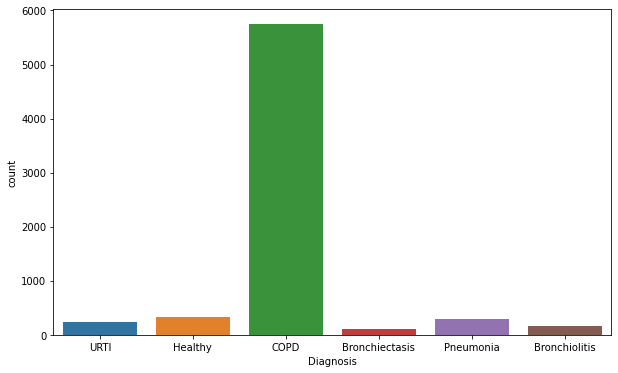

In [ ]:
'''Understand the distribution of diagnosis associated with respiratory cycle'''
plt.figure(figsize=(10,6))
sns.countplot(x=data['Diagnosis'])

The dataset is highly imbalanced ❌  
It is necessary to drop some data so that the model can learn better with a more balanced dataset ✅

In [ ]:
data = data.sort_values(by = 'multi_disease_label').reset_index()
data = data.drop(labels = range(0,5500))

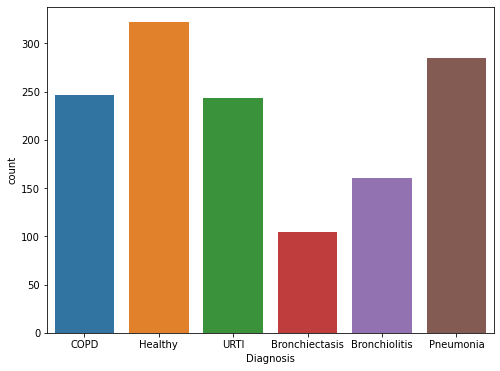

In [ ]:
plt.figure(figsize=(8,6))
sns.countplot(x=data['Diagnosis'])

In [ ]:
data['multi_disease_label'].value_counts()

1    322
5    285
0    246
2    243
4    160
3    104
Name: multi_disease_label, dtype: int64

## 2.3 Train Test Split 

In [ ]:
X = data['Path']
y= data['multi_disease_label']
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.1, stratify = y )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train , test_size=0.1, stratify = y_train )

In [ ]:
num_classes = data['multi_disease_label'].nunique()

In [ ]:
train_labels = tf.keras.utils.to_categorical(y_train.values, num_classes=num_classes)
test_labels = tf.keras.utils.to_categorical(y_test.values, num_classes=num_classes)
val_labels = tf.keras.utils.to_categorical(y_val.values, num_classes=num_classes)

# Part 3: Generate Spectrograms and Create Pipeline

## 3.1 Transform audio to spectrograms

It is because CNN model can only be trained by using image but not audio 🔕

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_waveform_and_label(file_path, label):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

train_ds = tf.data.Dataset.from_tensor_slices((X_train, train_labels))
train_ds = train_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, test_labels))
test_ds = test_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val ,val_labels))
val_ds = val_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [ ]:
def get_spectrogram(waveform,label):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  #equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)

  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram, label

train_spec_ds = train_ds.map(map_func=get_spectrogram, num_parallel_calls=AUTOTUNE)
test_spec_ds = test_ds.map(map_func=get_spectrogram, num_parallel_calls=AUTOTUNE)
val_spec_ds = val_ds.map(map_func=get_spectrogram, num_parallel_calls=AUTOTUNE)

In [ ]:
batch_size = 16
#spec

train_ds =  train_spec_ds.batch(batch_size)
test_ds = test_spec_ds.batch(batch_size)
val_ds =  val_spec_ds.batch(batch_size)

#caching
'''Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model'''
train_ds = train_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

# Part 4: Training the moodel 🖥


More than 20 models were trained using different kernel size, dropout layers, learning rate. The following model is adopted since it can achieve an average accuracy of 86% 🎉

In [ ]:
Adam = Adam(learning_rate=0.01)

es = EarlyStopping(verbose=1, patience=10, restore_best_weights=True)

model17 = Sequential()
model17.add(layers.Conv2D(32, (12, 12), input_shape=(1032, 129, 1), padding='same', activation='relu'))
model17.add(layers.MaxPool2D(pool_size=(6, 6)))
model17.add(layers.Dropout(rate=0.2))
model17.add(layers.Conv2D(16, (6, 6), padding='same', activation='relu'))
model17.add(layers.MaxPool2D(pool_size=(3, 3)))
model17.add(layers.Dropout(rate=0.2))
model17.add(layers.Conv2D(8, (3, 3), padding='same', activation='relu'))
model17.add(layers.MaxPool2D(pool_size=(2, 2)))
model17.add(layers.Dropout(rate=0.2))
model17.add(layers.Conv2D(4, (2, 2), padding='same', activation='relu'))
model17.add(layers.Flatten())
model17.add(layers.Dense(10, activation='relu'))
model17.add(layers.Dense(num_classes, activation='softmax'))


# recall = Recall()
model17.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy', tfa.metrics.F1Score(num_classes = num_classes), Recall()])

EPOCHS = 70
history17 = model17.fit(
    train_ds,
    validation_data = val_ds, epochs=EPOCHS,  callbacks =[es])

Epoch 1/70
69/69 [==============================] - 3s 30ms/step - loss: 1.6754 - accuracy: 0.2625 - f1_score: 0.1912 - recall_2: 0.0545 - val_loss: 1.5382 - val_accuracy: 0.2764 - val_f1_score: 0.1598 - val_recall_2: 0.1138
Epoch 2/70
69/69 [==============================] - 2s 26ms/step - loss: 1.4580 - accuracy: 0.3588 - f1_score: 0.2658 - recall_2: 0.1381 - val_loss: 1.3343 - val_accuracy: 0.4390 - val_f1_score: 0.3354 - val_recall_2: 0.1707
Epoch 3/70
69/69 [==============================] - 2s 26ms/step - loss: 1.3744 - accuracy: 0.4332 - f1_score: 0.3378 - recall_2: 0.1817 - val_loss: 1.2601 - val_accuracy: 0.4553 - val_f1_score: 0.3526 - val_recall_2: 0.2033
Epoch 4/70
69/69 [==============================] - 2s 28ms/step - loss: 1.3025 - accuracy: 0.4396 - f1_score: 0.3509 - recall_2: 0.2116 - val_loss: 1.1938 - val_accuracy: 0.4390 - val_f1_score: 0.3442 - val_recall_2: 0.2276
Epoch 5/70
69/69 [==============================] - 2s 26ms/step - loss: 1.2491 - accuracy: 0.4687 -

# Part 5: Evaludate the performance

## 5.1 Understand model loss / accuracy

In [ ]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
#     ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
#     ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

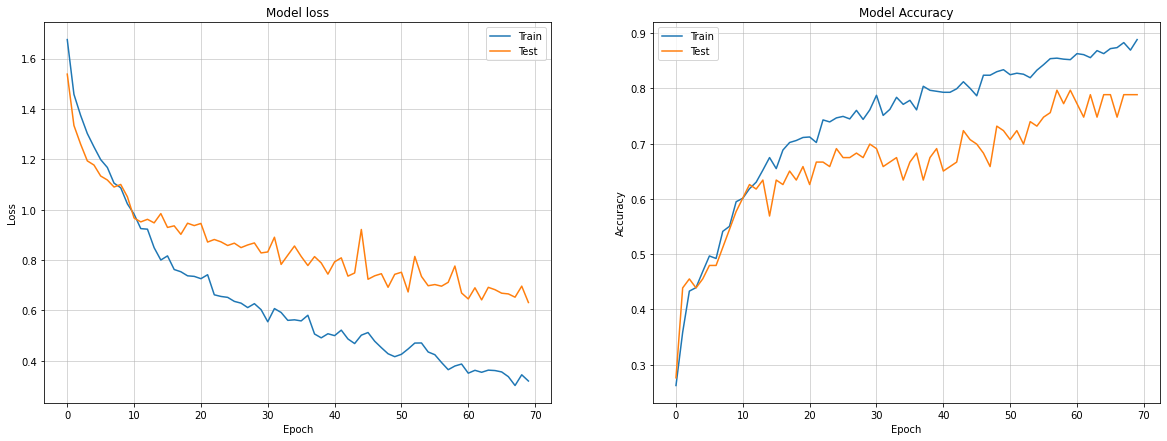

In [ ]:
plot_loss_accuracy(history17)

## 5.2 Classification Report

In [ ]:

y_pred17 = np.argmax(model17.predict(test_ds),axis=1)
y_true = np.argmax(test_labels,axis=1)
print(classification_report(y_true, y_pred17))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.73      0.94      0.82        32
           2       0.80      0.83      0.82        24
           3       1.00      0.90      0.95        10
           4       1.00      0.56      0.72        16
           5       0.82      0.79      0.81        29

    accuracy                           0.85       136
   macro avg       0.89      0.83      0.85       136
weighted avg       0.86      0.85      0.84       136



## 5.3 Confusion Matrix

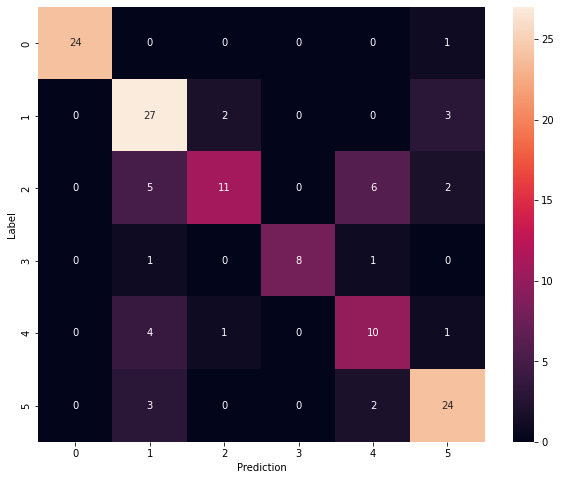

In [ ]:
bconfusion_mtx = tf.math.confusion_matrix(y_true, y_pred17)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [ ]:
model17.save('/content/drive/MyDrive/Deep_Breath/saved_models/resp_model_v4_model17_Tracy.h5')